## Imports

In [1]:
import helpers.set_path
import pandas as pd

import matplotlib.pyplot as plt
from pathlib import Path

from PIL import Image

import helpers.set_path

from src.data.load_data import get_train_loader, get_val_loader, get_test_loader, classes
from src.data.format_submissions import format_submissions

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
import torch
from torch import nn

import seaborn as sns
import pandas as pd
import numpy as np
import math
import wandb
from sklearn.metrics import log_loss, confusion_matrix, f1_score, accuracy_score, log_loss
from typing import List
from pytorch_lightning.loggers import WandbLogger

from src.models import Resnet50Model
from src.models import EfficientnetV2Model

from src.models import DensenetModel
from src.models import ViTModel

from src.models import VGG19Model
from src.models import InceptionV3Model
from src.models import EnsembleModel

from IPython.display import IFrame

/home/luca/miniconda3/envs/ccv1-gpu/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/luca/miniconda3/envs/ccv1-gpu/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/luca/miniconda3/envs/ccv1-gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-06-17 11:07:05.982617: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

## Load Models

### Best Model

In [2]:
best_model = ViTModel.load_from_checkpoint("../models/ViTModel.ckpt")
best_model.eval()

Some weights of the model checkpoint at google/vit-large-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTModel(
  (loss): CrossEntropyLoss()
  (f1_weighted): MulticlassF1Score()
  (f1_micro): MulticlassF1Score()
  (f1_macro): MulticlassF1Score()
  (model): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-23): 24 x ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=1024, out_features=1024, bias=True)
                (key): Linear(in_features=1024, out_features=1024, bias=True)
                (value): Linear(in_features=1024, out_features=1024, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features

### Models for Ensemble

#### DenseNet

In [3]:
densenet = DensenetModel.load_from_checkpoint("../models/DensenetModel.ckpt")
densenet.eval()

DensenetModel(
  (loss): CrossEntropyLoss()
  (f1_weighted): MulticlassF1Score()
  (f1_micro): MulticlassF1Score()
  (f1_macro): MulticlassF1Score()
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1

#### EfficientNet

In [4]:
efficientnet = EfficientnetV2Model.load_from_checkpoint("../models/EfficientnetV2Model.ckpt")
efficientnet.eval()

EfficientnetV2Model(
  (loss): CrossEntropyLoss()
  (f1_weighted): MulticlassF1Score()
  (f1_micro): MulticlassF1Score()
  (f1_macro): MulticlassF1Score()
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNorm

#### Inception

In [5]:
inception = InceptionV3Model.load_from_checkpoint("../models/InceptionV3Model.ckpt")
inception.eval()

/home/luca/miniconda3/envs/ccv1-gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/luca/miniconda3/envs/ccv1-gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


InceptionV3Model(
  (loss): CrossEntropyLoss()
  (f1_weighted): MulticlassF1Score()
  (f1_micro): MulticlassF1Score()
  (f1_macro): MulticlassF1Score()
  (model): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1

### Ensemble

In [6]:
best_weights = [0.2, 0.6, 0.2] # ViT, Densenet, Efficientnet (From the best run in sweep)
models = [densenet, efficientnet, inception]
ensemble_model = EnsembleModel(models, best_weights)

### Models before cropping

#### DenseNet

In [7]:
densenet_before_cropping = DensenetModel.load_from_checkpoint("../models/DensenetModel_before_cropping.ckpt")
densenet.eval()

DensenetModel(
  (loss): CrossEntropyLoss()
  (f1_weighted): MulticlassF1Score()
  (f1_micro): MulticlassF1Score()
  (f1_macro): MulticlassF1Score()
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1

#### ViT

In [8]:
ViT_before_croping = ViTModel.load_from_checkpoint("../models/ViTModel_before_cropping.ckpt")
ViT_before_croping.eval()

Some weights of the model checkpoint at google/vit-large-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTModel(
  (loss): CrossEntropyLoss()
  (f1_weighted): MulticlassF1Score()
  (f1_micro): MulticlassF1Score()
  (f1_macro): MulticlassF1Score()
  (model): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-23): 24 x ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=1024, out_features=1024, bias=True)
                (key): Linear(in_features=1024, out_features=1024, bias=True)
                (value): Linear(in_features=1024, out_features=1024, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features

## Load Data

In [9]:
val_loader = get_val_loader(32, 224, 0.05)

## Predict

In [10]:
trainer = Trainer(accelerator="gpu")
best_model_pred = trainer.predict(best_model, val_loader)

densenet_pred = trainer.predict(densenet, val_loader)
efficientnet_pred = trainer.predict(efficientnet, val_loader)
inception_pred = trainer.predict(inception, val_loader)
ensemble_preds = trainer.predict(ensemble_model, val_loader)
densenet_before_cropping_pred = trainer.predict(densenet_before_cropping, val_loader)
ViTModel_before_croping_pred = trainer.predict(ViT_before_croping, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 107/107 [00:14<00:00,  7.21it/s]


You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 107/107 [00:04<00:00, 21.64it/s]


You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 107/107 [00:03<00:00, 32.66it/s]


You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 107/107 [00:03<00:00, 34.14it/s]


You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 107/107 [00:07<00:00, 14.69it/s]


You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 107/107 [00:04<00:00, 21.96it/s]


You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 107/107 [00:14<00:00,  7.63it/s]


## Predicitions into DataFrame's

In [11]:
def preds_to_df(preds: List[np.ndarray]) -> pd.DataFrame:
    """
    Takes a list of predictions and converts them to a dataframe with the true labels
    """
    df = [batch['prediction'] for batch in preds]
    df = np.concatenate(df)

    df_ids = [list(batch['image_id']) for batch in preds]
    df_ids = np.concatenate(df_ids)

    df = pd.DataFrame(df, columns=classes)
    df.insert(0, "image_id", df_ids)

    return df

def ensemle_preds_to_df(preds: List[np.ndarray]) -> pd.DataFrame:
    """
    Takes a list of predictions and converts them to a dataframe with the true labels
    """
    df = [batch[1].cpu().numpy() for batch in preds]
    df = np.concatenate(df)

    df_ids = [list(batch[0]) for batch in preds]
    df_ids = np.concatenate(df_ids)

    df = pd.DataFrame(df, columns=classes)
    df.insert(0, "image_id", df_ids)

    return df

In [12]:
actual_df = [batch[2].cpu().numpy() for batch in ensemble_preds]
actual_df = np.concatenate(actual_df)

df_ids = [list(batch[0]) for batch in ensemble_preds]
df_ids = np.concatenate(df_ids)

actual_df = pd.DataFrame(actual_df, columns=classes)
actual_df.insert(0, "image_id", df_ids)

actual_df

,image_id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,ZJ000012,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,ZJ000017,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ZJ000019,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,ZJ000022,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ZJ000031,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
3395,ZJ016476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3396,ZJ016477,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3397,ZJ016478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3398,ZJ016480,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [13]:
best_model_preds_df = preds_to_df(best_model_pred)
densenet_preds_df = preds_to_df(densenet_pred)
efficientnet_preds_df = preds_to_df(efficientnet_pred)
inception_preds_df = preds_to_df(inception_pred)
ensemble_preds_df = ensemle_preds_to_df(ensemble_preds)
densenet_before_cropping_preds_df = preds_to_df(densenet_before_cropping_pred)
ViTModel_before_croping_preds_df = preds_to_df(ViTModel_before_croping_pred)

## Evaluation

Die Leistung der Modelle wurde von mehreren Metriken evaluiert: Accuracy pro Klasse, F1-Score (gewichtet, Makro und Mikro) und der Log-Loss. Durch die Verwendung dieser Metriken können wir ein umfassendes Bild der Modellleistung erhalten. Wir werden in diesem Abschnitt die Leistung jedes Modells im Detail betrachten.

In [14]:
y_true = actual_df.drop(columns='image_id').idxmax(axis=1).values
y_pred_best_model = best_model_preds_df.drop(columns='image_id').idxmax(axis=1).values
y_pred_densenet = densenet_preds_df.drop(columns='image_id').idxmax(axis=1).values
y_pred_efficientnet = efficientnet_preds_df.drop(columns='image_id').idxmax(axis=1).values
y_pred_inception = inception_preds_df.drop(columns='image_id').idxmax(axis=1).values
y_pred_ensemble = ensemble_preds_df.drop(columns='image_id').idxmax(axis=1).values
y_pred_densenet_before_cropping = densenet_before_cropping_preds_df.drop(columns='image_id').idxmax(axis=1).values
y_pred_ViTModel_before_croping = ViTModel_before_croping_preds_df.drop(columns='image_id').idxmax(axis=1).values

cm_best_model = confusion_matrix(y_true, y_pred_best_model)
cm_densenet = confusion_matrix(y_true, y_pred_densenet)
cm_efficientnet = confusion_matrix(y_true, y_pred_efficientnet)
cm_inception = confusion_matrix(y_true, y_pred_inception)
cm_ensemble = confusion_matrix(y_true, y_pred_ensemble)
cm_densenet_before_cropping = confusion_matrix(y_true, y_pred_densenet_before_cropping)
cm_ViTModel_before_croping = confusion_matrix(y_true, y_pred_ViTModel_before_croping)

labels = actual_df.columns[1:]

In [15]:
def plot_all_cms(cms, labels, titles):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
    axes = axes.flatten()

    for ax, cm, title in zip(axes, cms, titles):
        sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues', cbar=False)
        ax.set(xlabel="Predicted", ylabel="Actual", xticklabels=labels, yticklabels=labels, title=title)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

    fig.delaxes(axes[-1])

    plt.tight_layout()
    plt.show()

def plot_all_cms(cms, labels, titles):
    n = len(cms)  # Anzahl der zu plottenden cms
    ncols = 3  # Sie können diese Zahl ändern, um die Anzahl der Spalten in Ihrem Gitter anzupassen.
    nrows = math.ceil(n / ncols)  # Berechnet die Anzahl der Zeilen basierend auf der Anzahl der cms und Spalten

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*5))
    axes = axes.flatten()

    for i in range(len(axes)):
        if i < n:
            ax = axes[i]
            cm = cms[i]
            title = titles[i]
            sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues', cbar=False)
            ax.set(xlabel="Predicted", ylabel="Actual", xticklabels=labels, yticklabels=labels, title=title)
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        else:
            fig.delaxes(axes[i])  # Löscht alle überschüssigen Achsen

    plt.tight_layout()
    plt.show()



def get_accuracies_df(cms, titles):
    accuracies = []
    for cm in cms:
        accuracies.append(np.diag(cm) / np.sum(cm, axis=1))

    accuracies_df = pd.DataFrame(accuracies, columns=labels)
    accuracies_df.insert(0, "model", titles)
    return accuracies_df

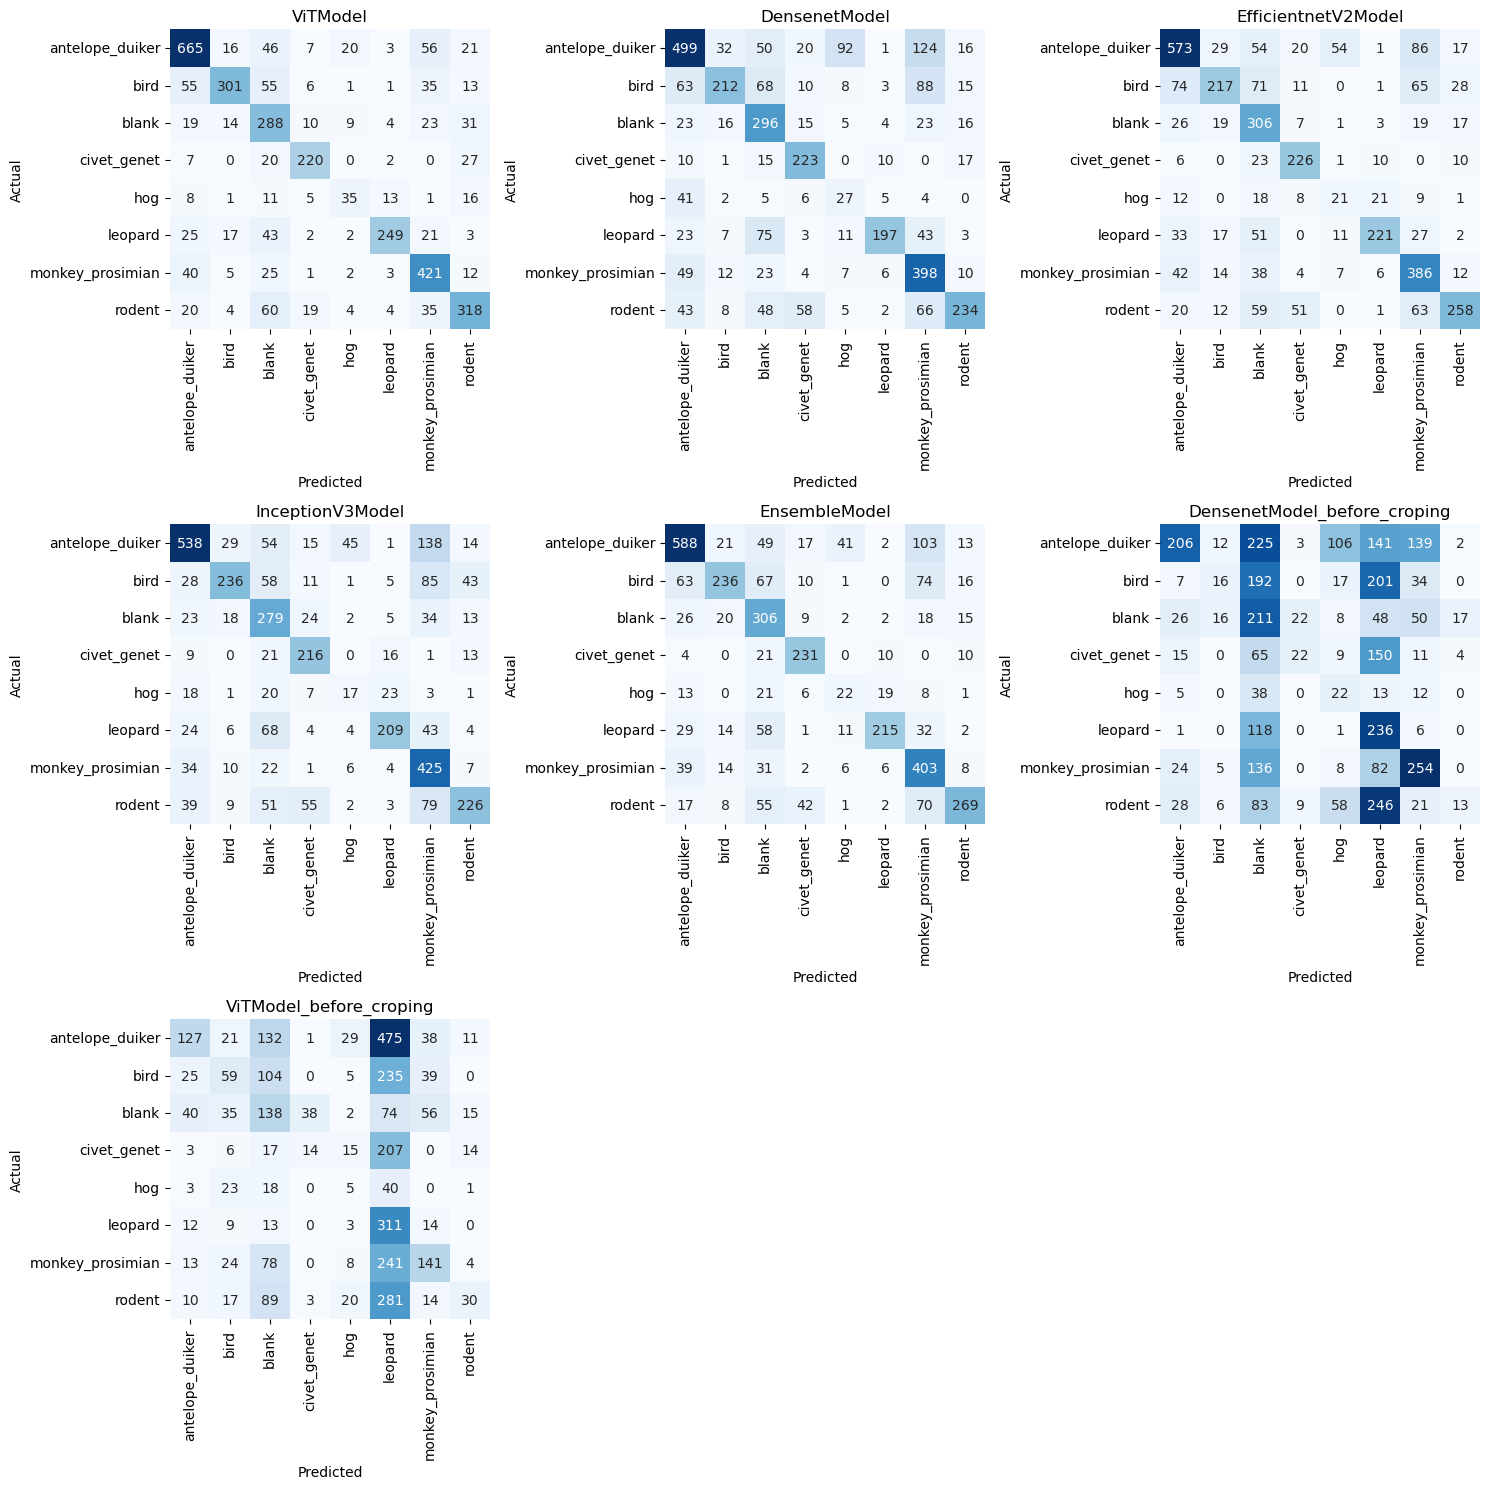

Accuracy für jedes Modell und für jede Klasse:


,model,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,ViTModel,0.797362,0.644540,0.723618,0.797101,0.388889,0.687845,0.827112,0.685345
1,DensenetModel,0.598321,0.453961,0.743719,0.807971,0.300000,0.544199,0.781925,0.504310
2,EfficientnetV2Model,0.687050,0.464668,0.768844,0.818841,0.233333,0.610497,0.758350,0.556034
3,InceptionV3Model,0.645084,0.505353,0.701005,0.782609,0.188889,0.577348,0.834971,0.487069
4,EnsembleModel,0.705036,0.505353,0.768844,0.836957,0.244444,0.593923,0.791749,0.579741
5,DensenetModel_before_croping,0.247002,0.034261,0.530151,0.079710,0.244444,0.651934,0.499018,0.028017
6,ViTModel_before_croping,0.152278,0.126338,0.346734,0.050725,0.055556,0.859116,0.277014,0.064655


In [16]:
cms = [cm_best_model,
       cm_densenet,
       cm_efficientnet,
       cm_inception,
       cm_ensemble,
       cm_densenet_before_cropping,
       cm_ViTModel_before_croping]

titles = [best_model.__class__.__name__,
          densenet.__class__.__name__,
          efficientnet.__class__.__name__,
          inception.__class__.__name__,
          ensemble_model.__class__.__name__,
          f'{densenet.__class__.__name__}_before_croping',
          f'{best_model.__class__.__name__}_before_croping']

plot_all_cms(cms, labels, titles)
print('Accuracy für jedes Modell und für jede Klasse:')
display(get_accuracies_df(cms, titles))

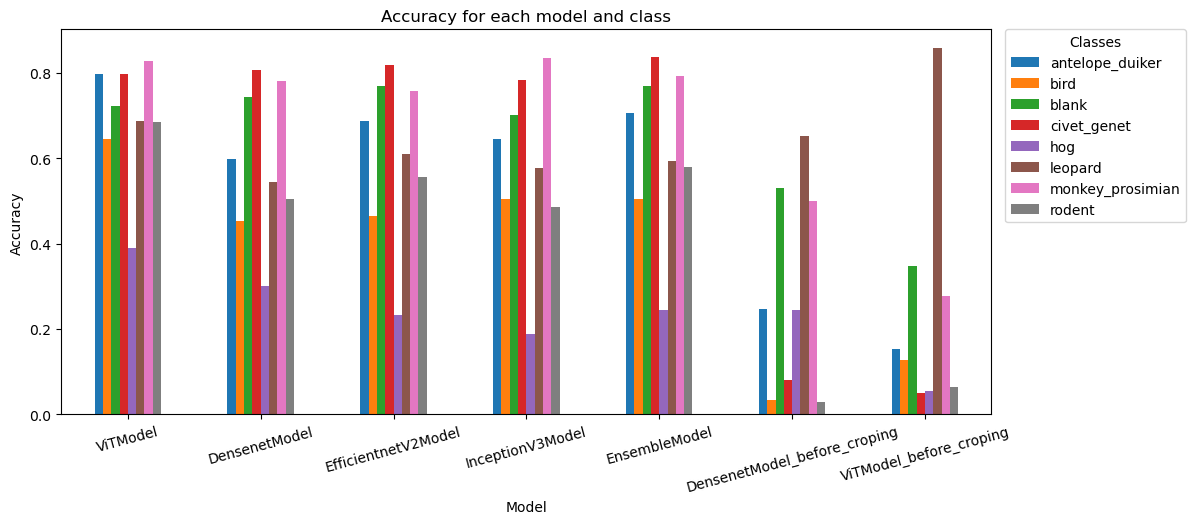

In [17]:
#bar plot of accuracies
accuracies_df = get_accuracies_df(cms, titles)
accuracies_df = accuracies_df.set_index('model')
accuracies_df.plot.bar(figsize=(12, 5))
plt.title('Accuracy for each model and class')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.legend(title='Classes', bbox_to_anchor=(1.015, 1), loc='upper left', borderaxespad=0.)
plt.xticks(rotation=15)
plt.show()

### DenseNet before cropping

In [18]:
IFrame('https://wandb.ai/safari_squad/ccv1/reports/Densenet-before-cropping--Vmlldzo0NjY5MTUx', width=1000, height=1000)

Der obenstehende Weights and Biases Report zeigt das beste Modell für die Bilder vor ihrer Zuschneidung. Es ist deutlich zu erkennen, dass selbst unser bestes Modell ein Minimum bei 1.309 erreicht. 

Im Vergleich zu den anderen Modellen (für die Bilder nach dem Cropping) wird schnell klar, dass die Genauigkeit pro Klasse bei den Bildern vor dem Cropping deutlich niedriger ist. Zudem unterscheidet sich die Verteilung der am besten vorhergesagten Klasse merklich. Innerhalb dieses Modells erweisen sich die Kategorien "blank" und "leopard" als stärkste, während "bird" als schwächste Klasse erscheint.

### ViTModel before cropping

In [19]:
IFrame('https://wandb.ai/safari_squad/ccv1/reports/ViTModel-before-cropping--Vmlldzo0NjY5MTY0', width=1000, height=1000)

Unser ViTModel, das insgesamt unser bestes Modell darstellt, schneidet überraschenderweise schlechter ab als das DenseNet mit einem val_log_loss von 1.39, bei den ungecropten Bilder. Die Erkennung der einzelnen Klassen fällt hier ebenfalls weniger präzise aus als bei den anderen Modellen, die nach dem Croppen trainiert wurden. 

Dennoch bietet es eine bemerkenswerte Überraschung: Die Klasse "leopard" wird mit einer Genauigkeit von 85% erstaunlich gut identifiziert. Dies stellt die beste Vorhersage aller Modelle dar. Im Gegensatz dazu sind "civet_genet" und "hog" die am schlechtesten performenden Klassen, mit einer Genauigkeit von lediglich 5% beziehungsweise 5,5%.

### ViTModel

In [20]:
IFrame('https://wandb.ai/safari_squad/ccv1/reports/ViTModel--Vmlldzo0NjM0NjQy', width=1000, height=1000)

Das ViTModel hat sich im Vergleich zu den anderen Modellen als das überlegenste erwiesen. Mit einem F1-Weighted von 0,7569, einem F1-Makro von 0,6678 und einem F1-Mikro von 0,7562 zeigt das ViTModel, dass es eine solide Leistung über alle Klassen hinweg bietet. Der Log-Loss von 0,7816 deutet ebenfalls darauf hin, dass das ViTModel über eine gute Klassifizierungsleistung verfügt.

Ausserdem kann man aus der Accuracytabelle entnehmen, dass das ViTModel bei der Klassifizierung von "Monkey_Prosimian", "civet_genet" und "monkey_prosimian" jeweils eine Accuracy von über 80% erreicht hat, was gute Ergebnisse sind. Die schlechteste Accuracy wurde bei der Klasse "hog" erreicht, wobei es trotzdem noch das beste aller anderen Modelle ist, dies Spricht dafür das "hog" eine schwierig zu klassifizierende Klasse sein muss. Ein Grund dafür könnte sein, dass die Klasse "hog" mit Abstand am wenigsten im Datensatz vertreten ist.

### DenseNet

In [21]:
IFrame('https://wandb.ai/safari_squad/ccv1/reports/DenseNet--Vmlldzo0NjM0NTgw', width=1000, height=1000)

Im Vergleich zum ViTModel hat das DensenetModel in allen Metriken eine geringere Leistung gezeigt. Der F1-Weighted-Score lag bei 0,6507, der F1-Makro bei 0,5698 und der F1-Mikro bei 0,6518. Der Log-Loss war mit 1,035 vergleichsweise höher, was auf eine geringere Klassifizierungsgenauigkeit hinweist. Trotzdem hat das DensenetModel bei der Klassifizierung der Klasse "Monkey_Prosimian" mit einer Genauigkeit von 0,815324 immer noch gut abgeschnitten.

### EfficientNet

In [22]:
IFrame('https://wandb.ai/safari_squad/ccv1/reports/EfficientNet--Vmlldzo0NjM0NzIy', width=1000, height=1000)

Das EfficientnetV2Model hat ebenfalls gute Ergebnisse erzielt, allerdings mit etwas niedrigeren Genauigkeitswerten als das ViT. Der F1-Weighted-Score lag bei 0,7047, der F1-Makro bei 0,6173 und der F1-Mikro bei 0,7029. Der Log-Loss von 0,9368 war ebenfalls etwas höher als der des ViTModells. Dennoch hat es von allen nicht-Transformer-Modellen die beste Leistung gezeigt.

Ebenfalls ist es spannend zu sehen, dass das EfficientNet mit dem Ensemble-Modell die einzigen beide Modelle sind, die als Best-Vorhergesagte-Klasse nicht "monkey_prosimian" haben sondern "civet_genet". Somit kann man schlussfolgern das das EfficientNet und das Ensemble-Modell die Klasse "civet_genet" besser klassifizieren können als die anderen Modelle. Diese Erkenntniss könnte für weitere Ensemble-Methoden unter Umständen hilfreich sein.

### Inception

In [23]:
IFrame('https://wandb.ai/safari_squad/ccv1/reports/Inception--Vmlldzo0NjM0NTAw', width=1000, height=1000)

Die Leistung des InceptionV3Model war im Vergleich zu den anderen Modellen nicht besonders gut.
Der F1-Weighted-Score betrug 0,6546, der F1-Makro bei 0,5801 und der F1-Mikro bei 0,6544. Der Log-Loss von 1,065 konnte ebenfalls nicht überzeugen.
Bei der Genauigkeiten pro Klasse verhält sich das Inception-Modell ähnlich wie das DenseNet-Modell mit Ausnahme, dass es "monkey_prosimian" deutlich besser klassifizieren konnte, jedoch "hog" deutlich schlechter.

### Ensemble

In [24]:
IFrame('https://wandb.ai/safari_squad/ccv1/reports/Ensemble--Vmlldzo0NjM1MzI3', width=1000, height=1000)

Das EnsembleModell konnte in vielen Metriken mit dem EfficientNet mithalten, z.B. konnte es mit dem F1-Makro (0,6416) und dem F1-Mikro (0.6794) das EfficientNet schlagen, jedoch sind Log-Loss (0,9489) und F1-Weighted (0,6808) trotzdem höher als die des EfficientNets. Die Accuracy pro Klasse ist ebenfalls ähnlich wie beim EfficientNet, jedoch konnte das Ensemble-Modell "rodent" besser klassifizieren als das EfficientNet.

### Schlussfolgerung

Alle Modelle zeigen eine beeindruckende Leistung bei der Identifizierung bestimmter Klassen, wobei bei anderen Klassen eine Verbesserung wünschenswert ist. Ein übergreifendes Problem ist die Klassifizierung der Kategorie "hog", die bei allen Modellen eine niedrige Genauigkeit aufweist. 

Die Klassifizierung der Klasse "hog" könnte durch eine weitere, tiefere Untersuchung der Daten evtl. noch verbessert werden.
Da diese Klasse mit Abstand am wenigsten im Datensatz vertreten ist, könnte man versuchen mehr Daten für diese Klasse zu sammeln oder weitere Datenvermehrungstechniken verwenden, sowie das Kopieren der Daten die dann leicht geändert werden um Overfitting zu vermeiden.

Wir sind insgesamt sehr zufrieden mit den Ergebnissen unserer Modelle. Alle Modelle haben eine gute Leistung erbracht, insbesondere bei der Klassifizierung der "Monkey_Prosimian"-Klasse. Das ViT-Modell sticht dabei besonders hervor, sowohl hinsichtlich der Genauigkeit als auch der F1-Scores und des Log-Loss. Diese Leistung zeigt die Effektivität der Transformer-Architektur Modells auch im Bereich der Bildklassifizierung und bestätigt seine Stärken in der Verarbeitung von Bildinformationen.

Trotz einiger Verbesserungsmöglichkeiten, wie z.B. das weitere Untersuchen der "Hog" Klasse oder weitere Ensemble-Methoden sowie weitere Transformer-Modelle auszutesten, unterstreichen diese Ergebnisse den Erfolg unserer Arbeit und die Qualität unserer Modelle. 